In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
os.getcwd()

'/home/riccardo/WORK-RESEARCH/MirrorRL'

# MirrorRL

In [6]:
def plot(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    for f in all_folders:
        data = pd.read_csv(path+f+"/progress.csv")
        fig = plt.figure(0)
        if limsup != None:
            data = data[data["time_total_s"]<limsup]
        labels = f.split(",")
        eta = labels[1][4:]
        # "time_total_s" "average_reward" "q_error_train" "kl" "entropy"
        plt.plot(data["time_total_s"], data["average_reward"], label=eta)
    plt.legend()
    plt.show()

def plot_all(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    for f in all_folders:
        df = pd.read_csv(path+f+"/progress.csv")
        if limsup != None:
            df = df[df["time_total_s"]<limsup]
        # extract eta 
        labels = f.split(",")
        eta = labels[1][4:]
        # 
        axs[0, 0].plot(df["time_total_s"], df["average_reward"], label=eta)
        axs[0, 0].set_title("episode_rewards")
        axs[1, 0].plot(df["time_total_s"], df["q_error_train"], label=eta)
        axs[1, 0].set_title("loss")
        axs[1, 0].set_yscale('log')
        axs[0, 1].plot(df["time_total_s"], df["kl"], label=eta)
        axs[0, 1].set_title("kl")
        axs[0, 1].set_yscale('log')
        axs[1, 1].plot(df["time_total_s"], df["entropy"], label=eta)
        axs[1, 1].set_title("ent")
    plt.legend()
    fig.tight_layout()

In [90]:
def plot_all_av_std(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    df = pd.DataFrame()
    for f in all_folders:
        _df = pd.read_csv(path+f+"/progress.csv")
        if limsup != None:
            _df = _df[_df["time_total_s"]<limsup]
        df = pd.concat([df, _df], ignore_index=True)

    df = df[['average_reward', 'q_error_train', "kl", "entropy", "experiment_id", "time_total_s", "time_since_restore", "iterations_since_restore"]]								  
    df = df.pivot_table(index= "iterations_since_restore", aggfunc=[np.mean,  np.std])
    
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["average_reward"]
    dyfit = df["std"]["average_reward"]
    axs[0, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[0, 0].plot(xfit, yfit, color='orange', alpha=0.7)
    axs[0, 0].set_title("eval_rewards")
    
    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["q_error_train"]
    dyfit = df["std"]["q_error_train"]
    axs[1, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[1, 0].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 0].set_title("loss")
    axs[1, 0].set_yscale('log')

    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["kl"]
    dyfit = df["std"]["kl"]
    axs[0, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[0, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[0, 1].set_title("kl") 
    axs[0, 1].set_yscale('log')

    xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["entropy"]
    dyfit = df["std"]["entropy"]
    axs[1, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[1, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 1].set_title("ent")

    fig.tight_layout()
    plt.savefig(path.replace("/","_"))
    # return df


### Find best $\eta$

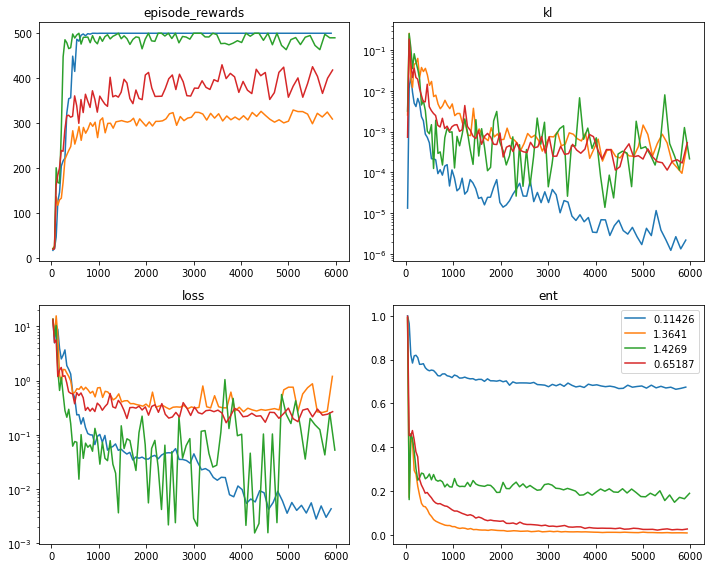

In [362]:
path = "ray_results/run_2022-05-16_15-43-05/"
plot_all(path,6000) 

### Plot average/std across seeds, $\eta=0.1$

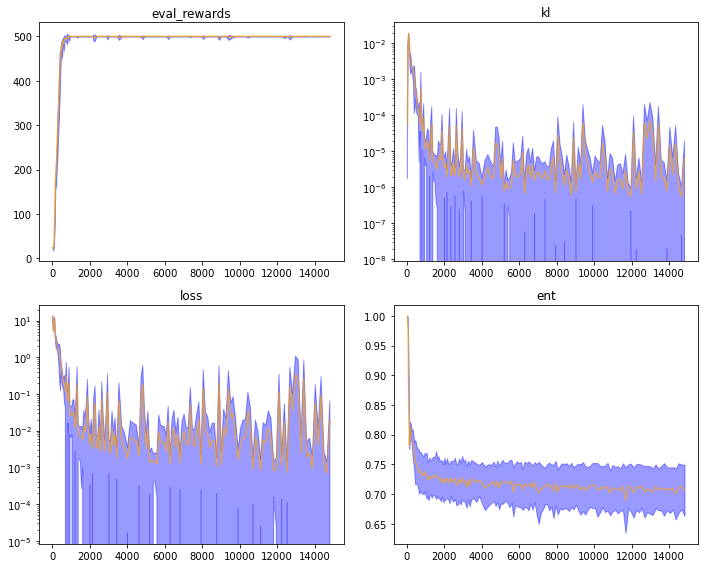

In [79]:
path = "ray_results/run_2022-05-19_14-13-03/"
plot_all_av_std(path,None)

# A2C

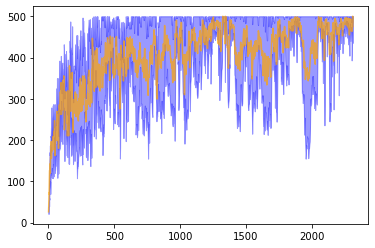

In [87]:
df = pd.read_csv("/home/riccardo/WORK-RESEARCH/MirrorRL/results/solving_cartpole/solving_cartpole/21/manager_data/data.csv")
df = df[df["tag"]=="eval_rewards"]
df = df.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
xfit = df["mean"]["dw_time_elapsed"]["eval_rewards"]
yfit = df["mean"]["value"]["eval_rewards"]
dyfit = df["std"]["value"]["eval_rewards"]
plt.fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
plt.plot(xfit, yfit, color='orange', alpha=0.7)

In [88]:
def plot_rlberry_exp(path):
    df = pd.read_csv(path + "/data.csv")
    df = df[(df["tag"]=="eval_rewards") | (df["tag"]=="loss") | (df["tag"]=="kl") | (df["tag"]=="ent")]
    df = df.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    xfit = df["mean"]["dw_time_elapsed"]["eval_rewards"]
    yfit = df["mean"]["value"]["eval_rewards"]
    dyfit = df["std"]["value"]["eval_rewards"]
    axs[0, 0].fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
    axs[0, 0].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[0, 0].set_title("eval_rewards")

    xfit = df["mean"]["dw_time_elapsed"]["loss"]
    yfit = df["mean"]["value"]["loss"]
    dyfit = df["std"]["value"]["loss"]
    axs[1, 0].fill_between(xfit, yfit - dyfit, yfit+dyfit, color='blue', alpha=0.4)
    axs[1, 0].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 0].set_title("loss")

    xfit = df["mean"]["dw_time_elapsed"]["kl"]
    yfit = df["mean"]["value"]["kl"]
    dyfit = df["std"]["value"]["kl"]
    axs[0, 1].fill_between(xfit, np.maximum(yfit - dyfit,0), yfit+dyfit, color='blue', alpha=0.4)
    axs[0, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[0, 1].set_title("kl") 

    xfit = df["mean"]["dw_time_elapsed"]["ent"]
    yfit = df["mean"]["value"]["ent"]
    dyfit = df["std"]["value"]["ent"]
    axs[1, 1].fill_between(xfit, np.maximum(yfit - dyfit,0), yfit+dyfit, color='blue', alpha=0.4)
    axs[1, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 1].set_title("ent")

    fig.tight_layout()
    plt.savefig(path.replace("/","_"))

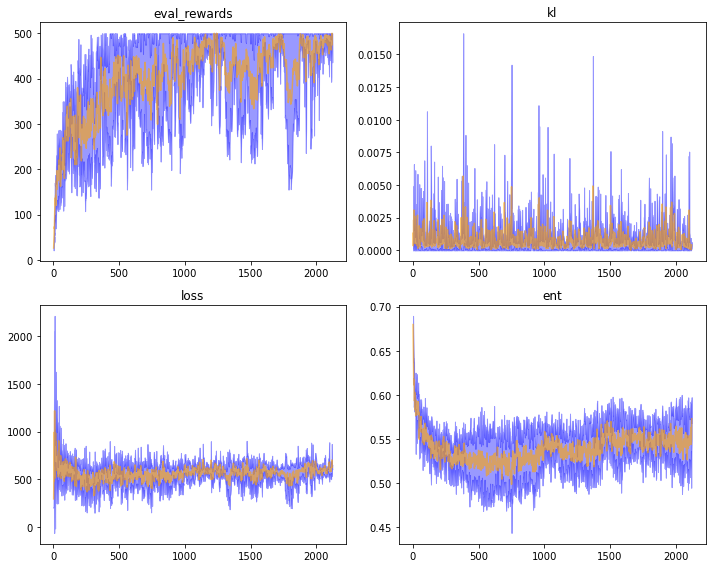

In [89]:
path = "results/solving_cartpole/solving_cartpole/22/manager_data"
plot_rlberry_exp(path)